In [27]:
import torch
import pandas as pd
import numpy as np
import gc
import math
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import userdata, drive
from huggingface_hub import login
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [2]:
HF_TOKEN = userdata.get('HF_TOKEN')
login(token=HF_TOKEN)
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# Load model
model_name = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "left"
tokenizer.model_max_length = 4096

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
model = torch.compile(model)
model.config.pad_token_id = tokenizer.pad_token_id
embedder = SentenceTransformer('all-MiniLM-L6-v2')

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
# Load datasets
df_train = pd.read_csv("/content/drive/MyDrive/266/lfud_logic_train.csv")
df_val = pd.read_csv("/content/drive/MyDrive/266/lfud_logic_val.csv")

inputs_train = df_train["input"].tolist()
labels_train = df_train["label"].tolist()

inputs_val = df_val["input"].tolist()
labels_val = df_val["label"].tolist()

# Label mappings
label2id = {
    'faulty generalization': 0, 'false causality': 1, 'circular reasoning': 2,
    'ad populum': 3, 'false dilemma': 4, 'fallacy of relevance': 5,
    'ad hominem': 6, 'appeal to emotion': 7, 'fallacy of extension': 8,
    'fallacy of credibility': 9, 'intentional fallacy': 10, 'deductive fallacy': 11
}
id2label = {v: k for k, v in label2id.items()}

In [107]:
# Prompt and extraction functions
def detect_fallacy_prompt(statement, examples_context=None):
    base_prompt = (
      f"Identify the most likely logical fallacy in this statement:\n"
      f"{statement}\n"
      f"Fallacies (choose one from this list): {', '.join(label2id.keys())}.\n"
      f"Name the fallacy, then explain briefly.\n"
    )
    if examples_context:
        return (
            f"Here are some examples of confusing arguments, along with explanations of their logical fallacies. You can refer to them for guidance:\n"
            f"{examples_context}\n\n"
            f"Now, analyze the next argument:"
            f"{base_prompt}"
        )
    else:
        return base_prompt

def extract_fallacy(response):
    response = response.lower().replace("-", " ")
    words = set(response.split())
    for fallacy in label2id:
        if all(word in words for word in fallacy.lower().split()):
            return fallacy
    return "none"

In [6]:
# Uncertainty Metrics
def calculate_disagreement(responses):
    labels = [extract_fallacy(r) for r in responses]
    return len(set(labels)) / len(labels), labels

def calculate_entropy(labels):
    counts = pd.Series(labels).value_counts(normalize=True)
    return -np.sum([p * math.log2(p + 1e-10) for p in counts])

def reasoning_consistency(responses):
    embeddings = embedder.encode(responses)
    sim_matrix = cosine_similarity(embeddings)
    return np.mean(sim_matrix[np.triu_indices_from(sim_matrix, k=1)])


In [119]:
def generate_batch_responses(prompts, temperature=0.7, max_total_tokens=2048, batch_size=8, default_max_new_tokens=80, num_return_sequences=1):
    responses = []

    for i in range(0, len(prompts), batch_size):
        batch = prompts[i:i + batch_size]

        encoded = tokenizer(batch, return_tensors="pt", padding=True, truncation=False)
        input_ids = encoded["input_ids"].to(model.device)
        attention_mask = encoded["attention_mask"].to(model.device)

        input_lengths = attention_mask.sum(dim=1).tolist()
        max_input_length = max(input_lengths)

        available_tokens = max_total_tokens - max_input_length
        max_new_tokens = min(default_max_new_tokens, max(16, available_tokens))

        if available_tokens < default_max_new_tokens:
            print(f"[NOTICE] Reducing generation length to {max_new_tokens} due to long input (batch {i}-{i + batch_size})")

        with torch.inference_mode():
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=max_new_tokens,
                temperature=temperature,
                top_p=0.9,
                do_sample=True,
                num_return_sequences=num_return_sequences,
                pad_token_id=tokenizer.pad_token_id
            )

        for batch_idx in range(len(batch)):
            input_len = input_ids[batch_idx].shape[0]
            for seq_idx in range(num_return_sequences):
                idx = batch_idx * num_return_sequences + seq_idx
                output_ids = outputs[idx]
                response = tokenizer.decode(output_ids[input_len:], skip_special_tokens=True)
                responses.append(response.strip())

    return responses


In [8]:
# Evaluation
def evaluate_fallacy_predictions(df):
    y_true = df["true_label"].astype(str)
    y_pred = df["predicted_label"].astype(str)
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))
    cm = confusion_matrix(y_true, y_pred, labels=sorted(y_true.unique()))
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=sorted(y_true.unique()), yticklabels=sorted(y_true.unique()))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

def validation_predictions(examples_context=None, batch_size=8):
    val_results = []
    true_labels_str = [id2label[int(lbl)] for lbl in labels_val]
    for i in tqdm(range(0, len(inputs_val), batch_size), desc="Running validation"):
        batch_inputs = inputs_val[i:i + batch_size]
        batch_labels = true_labels_str[i:i + batch_size]
        batch_prompts = [detect_fallacy_prompt(arg, examples_context) for arg in batch_inputs]
        responses = generate_batch_responses(batch_prompts, batch_size=batch_size)
        for j, r in enumerate(responses):
            val_results.append({
                "input": batch_inputs[j],
                "true_label": batch_labels[j],
                "predicted_label": extract_fallacy(r),
                "response": r
            })
    df = pd.DataFrame(val_results)
    prompt_type = "Few-shot" if examples_context else "Baseline"
    print(f"\nValidation Results - {prompt_type} Prompt")
    evaluate_fallacy_predictions(df)
    return df

Running validation: 100%|██████████| 23/23 [01:26<00:00,  3.78s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Validation Results - Baseline Prompt
Accuracy: 0.2139

Classification Report:
                        precision    recall  f1-score   support

            ad hominem     0.6944    0.5814    0.6329        43
            ad populum     0.8462    0.3143    0.4583        35
     appeal to emotion     0.5294    0.3000    0.3830        30
    circular reasoning     0.7500    0.1304    0.2222        23
     deductive fallacy     0.0000    0.0000    0.0000        27
fallacy of credibility     0.7500    0.2500    0.3750        24
  fallacy of extension     1.0000    0.0370    0.0714        27
  fallacy of relevance     0.4000    0.0741    0.1250        27
       false causality     0.4706    0.2424    0.3200        33
         false dilemma     0.4286    0.2500    0.3158        24
 faulty generalization     0.4000    0.1395    0.2069        43
   intentional fallacy     0.0000    0.0000    0.0000        24
                  none     0.0000    0.0000    0.0000         0

              accuracy 

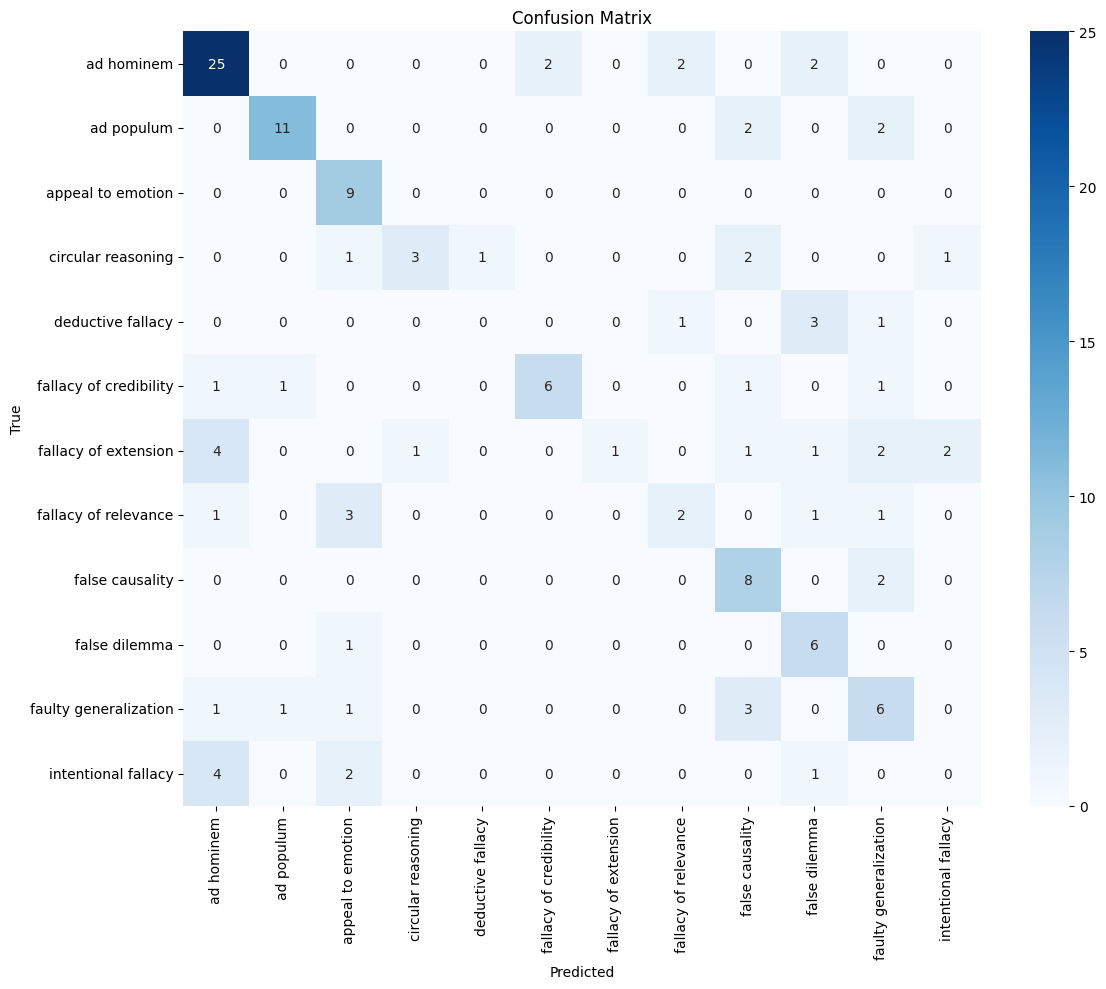

In [64]:
val_baseline_df = validation_predictions(batch_size=16)

In [65]:
# Uncertainty estimation
print("Running training uncertainty analysis...")
N = 5
batch_size = 16
train_results = []

for i in tqdm(range(0, len(inputs_train), batch_size)):
    batch_inputs = inputs_train[i:i + batch_size]
    batch_labels = labels_train[i:i + batch_size]
    prompts = [detect_fallacy_prompt(arg) for arg in batch_inputs]
    responses = generate_batch_responses(prompts, batch_size=batch_size, num_return_sequences=N)
    grouped = [responses[j * N:(j + 1) * N] for j in range(len(batch_inputs))]
    for j, group in enumerate(grouped):
        disagreement, labels = calculate_disagreement(group)
        entropy = calculate_entropy(labels)
        consistency = reasoning_consistency(group)
        train_results.append({
            "index": i + j,
            "input": batch_inputs[j],
            "true_label": batch_labels[j],
            "responses": group,
            "predicted_labels": labels,
            "disagreement": disagreement,
            "entropy": entropy,
            "consistency": consistency
        })
    if i % (batch_size * 10) == 0:
        gc.collect()
        torch.cuda.empty_cache()

train_df = pd.DataFrame(train_results)
train_df.to_csv("/content/drive/MyDrive/266/train_metrics_final.csv", index=False)


Running training uncertainty analysis...


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*a

In [66]:
# Top 10 most uncertain samples
train_df["inconsistency"] = 1 - train_df["consistency"]
top_entropy = train_df.sort_values("entropy", ascending=False).head(10)
top_disagreement = train_df.sort_values("disagreement", ascending=False).head(10)
top_inconsistency = train_df.sort_values("inconsistency", ascending=False).head(10)

top_entropy.to_csv("/content/drive/MyDrive/266/lfud_top_entropy.csv", index=False)
top_disagreement.to_csv("/content/drive/MyDrive/266/lfud_top_disagreement.csv", index=False)
top_inconsistency.to_csv("/content/drive/MyDrive/266/lfud_top_inconsistency.csv", index=False)


In [67]:
top_entropy["true_label_str"] = top_entropy["true_label"].map(id2label)
top_disagreement["true_label_str"] = top_disagreement["true_label"].map(id2label)
top_inconsistency["true_label_str"] = top_inconsistency["true_label"].map(id2label)

In [71]:
top_entropy_annotations = pd.DataFrame([
    (2351, "This is circular reasoning because the conclusion that the speaker can say what they want is justified solely by restating the premise that they have free speech."),
    (879, "This is a fallacy of relevance; the statement about sports bringing people together is irrelevant to the factual claim about Olympic athletes' training."),
    (3230, "This is an appeal to emotion; threatening eternal damnation is designed to provoke fear rather than provide a rational argument for belief in God."),
    (23, "This is a deductive fallacy because it assumes that no family members have saved enough money based on the fact that they haven't traveled, which doesn’t logically follow."),
    (2433, "This is an intentional fallacy because it frames the issue emotionally, asking a loaded question that equates disagreement with opposing freedom."),
    (2177, "This is an ad hominem fallacy; it dismisses Lisa's belief based on her background (being brainwashed) rather than addressing the belief itself."),
    (2345, "This is a faulty generalization, making a sweeping claim about all parents based on limited or anecdotal evidence."),
    (2930, "This is a fallacy of credibility; the 'medicine man' presents himself as a trustworthy figure while using vague appeals to nature to undermine modern medicine."),
    (1361, "This is an appeal to emotion; the salesperson appeals to vanity and flattery rather than offering logical reasons to buy the car."),
    (1148, "This is a fallacy of credibility; it appeals to divine authority ('Supreme Judge,' 'providence') as justification instead of providing rational arguments."),
], columns=["index", "explanation"])

top_disagreement_annotations = pd.DataFrame([
    (23, "This is a deductive fallacy; it assumes that because no one in the family has been to Europe, none have saved money, which doesn’t logically follow."),
    (2351, "This is circular reasoning; it uses the right to free speech to justify saying anything without considering limits, restating the premise as the conclusion."),
    (2433, "This is an intentional fallacy; the question is emotionally loaded, equating gun rights with freedom in general to shut down dissent."),
    (3230, "This is an appeal to emotion; it uses fear (of going to hell) to force belief in God rather than providing logical justification."),
    (879, "This is a fallacy of relevance; the emotional idea that 'sports bring people together' doesn’t logically connect to Olympic athletes training."),
    (2177, "This is an ad hominem fallacy; it attacks the source of the belief (Lisa’s upbringing) instead of evaluating the belief itself."),
    (2384, "This is an intentional fallacy; it omits crucial discrediting information while presenting selective facts to falsely build a moral image."),
    (807, "This is circular reasoning; it defines reptiles as animals that don’t produce milk and then concludes they don’t produce milk based on that definition."),
    (1516, "This is an ad populum fallacy; it suggests someone should 'move on' simply because everyone else supposedly has, relying on popularity rather than reasoning."),
    (464, "This is a fallacy of extension; Person B exaggerates and misrepresents Person A’s statement by turning it into an accusation of laziness."),
], columns=["index", "explanation"])

top_inconsistency_annotations = pd.DataFrame([
    (1892, "This is an appeal to emotion; 'snarl words' are used to provoke negative emotional reactions rather than engage with the argument logically."),
    (1953, "This is circular reasoning; repeating a claim without providing new evidence just restates the conclusion without support."),
    (2471, "This is a faulty generalization, likely referring to a slippery slope, where extreme outcomes are predicted without sufficient evidence."),
    (2860, "This is an ad hominem fallacy; it attacks the person making the argument rather than the argument itself."),
    (1585, "This is a deductive fallacy; saying something that doesn't logically follow in a conversation reflects a breakdown in logical structure or coherence."),
    (2949, "This is a faulty generalization and slippery slope fallacy; it assumes one event (A) will inevitably lead to a chain of extreme consequences without justification."),
    (2911, "This is circular reasoning; it likely involves restating a claim as evidence for itself without introducing new reasoning."),
    (2897, "This is an ad hominem fallacy; it identifies the error of attacking the person instead of addressing their argument."),
    (1042, "This is an intentional fallacy; it distracts or shifts blame by asserting an opinion while ignoring counterarguments or complexity."),
    (2559, "This is an intentional fallacy; the question is loaded and presumes guilt, making it impossible to answer without appearing guilty."),
], columns=["index", "explanation"])

In [72]:
def create_examples_context(annotations_df, top_k):
    merged = pd.merge(top_k, annotations_df, on="index", how="inner")
    examples_context = [
        (
            f"Example argument: {row['input']}\n"
            f"Correct reasoning and fallacy: {row['explanation']}\n"
        )
        for _, row in merged.iterrows()
    ]
    return "\n".join(examples_context)

In [73]:
# Create active prompt
entropy_examples_context = create_examples_context(top_entropy, top_entropy_annotations)
disagreement_examples_context = create_examples_context(top_disagreement, top_disagreement_annotations)
inconsistency_examples_context = create_examples_context(top_inconsistency, top_inconsistency_annotations)

In [74]:
output_dir = "/content/drive/MyDrive/266"
# Save context to Google Drive
with open(f"{output_dir}/entropy_examples_context.txt", "w", encoding="utf-8") as f:
    f.write(entropy_examples_context)

with open(f"{output_dir}/disagreement_examples_context.txt", "w", encoding="utf-8") as f:
    f.write(disagreement_examples_context)

with open(f"{output_dir}/inconsistency_examples_context.txt", "w", encoding="utf-8") as f:
    f.write(inconsistency_examples_context)

Running validation: 100%|██████████| 23/23 [01:58<00:00,  5.17s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Validation Results - Few-shot Prompt
Accuracy: 0.1833

Classification Report:
                        precision    recall  f1-score   support

            ad hominem     0.6364    0.4884    0.5526        43
            ad populum     0.7778    0.4000    0.5283        35
     appeal to emotion     0.2000    0.0333    0.0571        30
    circular reasoning     1.0000    0.0435    0.0833        23
     deductive fallacy     0.7500    0.1111    0.1935        27
fallacy of credibility     0.3333    0.0833    0.1333        24
  fallacy of extension     0.2500    0.0741    0.1143        27
  fallacy of relevance     0.5000    0.0370    0.0690        27
       false causality     0.4706    0.2424    0.3200        33
         false dilemma     0.5714    0.1667    0.2581        24
 faulty generalization     0.4118    0.1628    0.2333        43
   intentional fallacy     0.5000    0.0833    0.1429        24
                  none     0.0000    0.0000    0.0000         0

              accuracy 

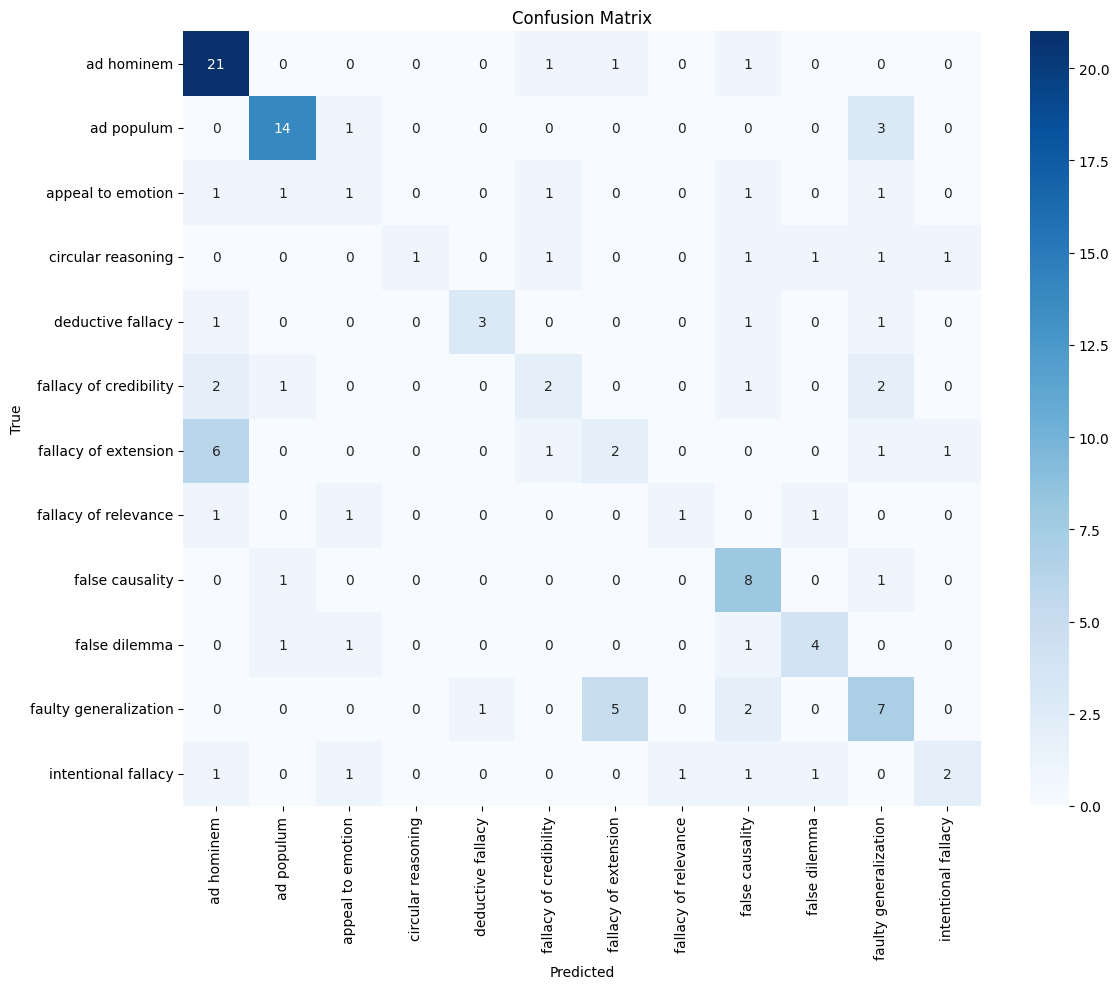

Running validation: 100%|██████████| 23/23 [02:01<00:00,  5.26s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Validation Results - Few-shot Prompt
Accuracy: 0.1972

Classification Report:
                        precision    recall  f1-score   support

            ad hominem     0.6765    0.5349    0.5974        43
            ad populum     0.8000    0.1143    0.2000        35
     appeal to emotion     0.1111    0.0333    0.0513        30
    circular reasoning     0.7500    0.1304    0.2222        23
     deductive fallacy     0.5333    0.2963    0.3810        27
fallacy of credibility     0.7500    0.1250    0.2143        24
  fallacy of extension     0.5000    0.0741    0.1290        27
  fallacy of relevance     0.6000    0.1111    0.1875        27
       false causality     0.5238    0.3333    0.4074        33
         false dilemma     0.4667    0.2917    0.3590        24
 faulty generalization     0.4000    0.1395    0.2069        43
   intentional fallacy     0.0000    0.0000    0.0000        24
                  none     0.0000    0.0000    0.0000         0

              accuracy 

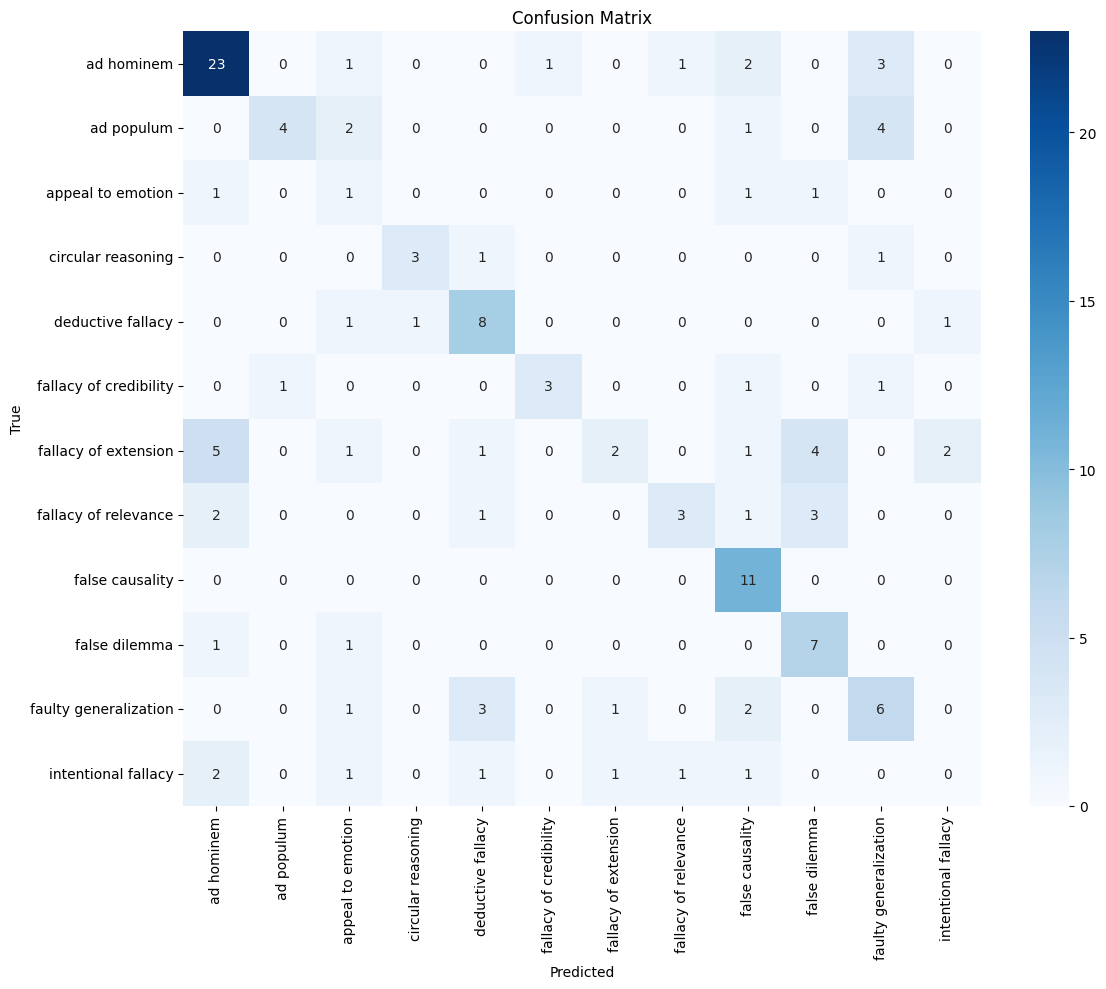

Running validation: 100%|██████████| 23/23 [01:45<00:00,  4.59s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Validation Results - Few-shot Prompt
Accuracy: 0.2333

Classification Report:
                        precision    recall  f1-score   support

            ad hominem     0.6087    0.6512    0.6292        43
            ad populum     0.5455    0.1714    0.2609        35
     appeal to emotion     0.5556    0.3333    0.4167        30
    circular reasoning     0.4444    0.1739    0.2500        23
     deductive fallacy     1.0000    0.1481    0.2581        27
fallacy of credibility     0.8333    0.2083    0.3333        24
  fallacy of extension     0.3333    0.0741    0.1212        27
  fallacy of relevance     0.0000    0.0000    0.0000        27
       false causality     0.5500    0.3333    0.4151        33
         false dilemma     0.4118    0.2917    0.3415        24
 faulty generalization     0.3571    0.1163    0.1754        43
   intentional fallacy     0.1667    0.0833    0.1111        24
                  none     0.0000    0.0000    0.0000         0

              accuracy 

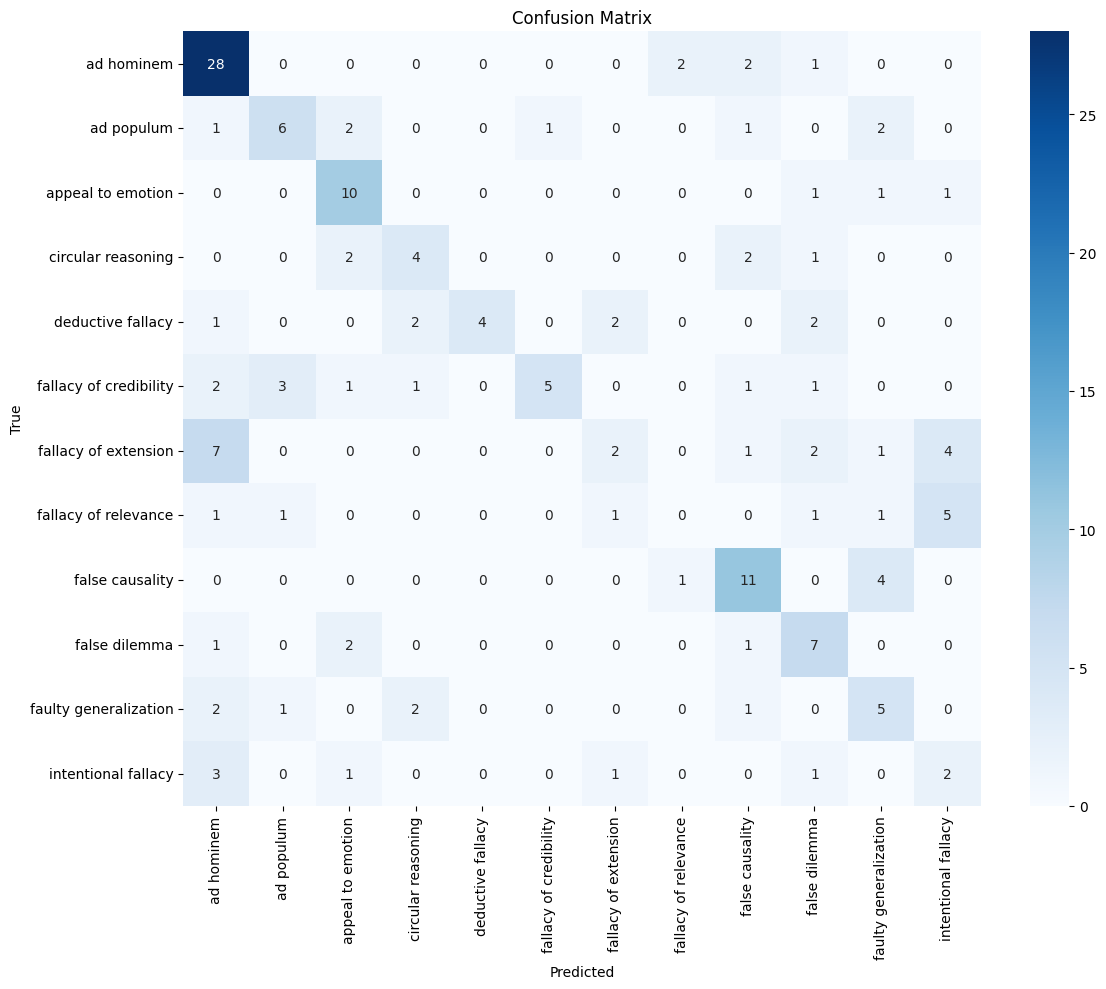

In [75]:
# Active prompting validation
val_entropy_df = validation_predictions(entropy_examples_context, batch_size=16)
val_disagreement_df = validation_predictions(disagreement_examples_context, batch_size=16)
val_inconsistency_df = validation_predictions(inconsistency_examples_context, batch_size=16)

In [111]:
import re

def extract_fallacy_climate(response):
    response = response.lower().replace("-", " ")
    response = re.sub(r'[^\w\s]', '', response)
    response = re.sub(r'\s+', ' ', response).strip()

    for fallacy in label2id:
        fallacy_normalized = fallacy.lower().replace("-", " ")
        if fallacy_normalized in response:
            return fallacy

    patterns = [
        r'answer:\s*(.+)',
        r'the fallacy is\s*(.+)',
        r'is an?\s+(.+?)\s+fallacy',
        r'fallacy of\s+(.+)'
    ]

    for pattern in patterns:
        match = re.search(pattern, response)
        if match:
            candidate = match.group(1).strip()
            for fallacy in label2id:
                if candidate in fallacy.lower():
                    return fallacy

    return "none"


In [114]:
# LogicClimate dataset evaluation
def climate_predictions(examples_context=None, batch_size=16):
    results = []
    true_labels_str = [str(lbl).strip().lower() for lbl in logic_climate_labels]

    for i in tqdm(range(0, len(logic_climate_inputs), batch_size), desc="Running LogicClimate Evaluation"):
        batch_inputs = logic_climate_inputs[i:i + batch_size]
        batch_labels = true_labels_str[i:i + batch_size]
        batch_prompts = [detect_fallacy_prompt(arg, examples_context) for arg in batch_inputs]
        responses = generate_batch_responses(batch_prompts, batch_size=batch_size)

        for j, r in enumerate(responses):
            results.append({
                "input": batch_inputs[j],
                "true_label": batch_labels[j],
                "predicted_label": extract_fallacy_climate(r),
                "response": r
            })

    df = pd.DataFrame(results)
    prompt_type = "Few-shot" if examples_context else "Baseline"
    print(f"\nLogicClimate Evaluation Results - {prompt_type} Prompt")
    evaluate_fallacy_predictions(df)
    return df


In [81]:
# Load and clean LogicClimate
logic_climate_all = pd.read_csv("https://raw.githubusercontent.com/causalNLP/logical-fallacy/main/data/climate_all.csv")
logic_climate_all.dropna(subset=['source_article', 'logical_fallacies'], inplace=True)
logic_climate_all['logical_fallacies'] = logic_climate_all['logical_fallacies'].replace({
    'intentional': 'intentional fallacy',
    'fallacy of logic': 'deductive fallacy'
})
logic_climate_all = logic_climate_all[logic_climate_all['logical_fallacies'] != 'equivocation']

logic_climate_inputs = logic_climate_all['source_article'].tolist()
logic_climate_labels = logic_climate_all['logical_fallacies'].tolist()


Running LogicClimate Evaluation: 100%|██████████| 81/81 [05:11<00:00,  3.85s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitali


LogicClimate Evaluation Results - Baseline Prompt
Accuracy: 0.1588

Classification Report:
                        precision    recall  f1-score   support

            ad hominem     0.3707    0.4479    0.4057        96
            ad populum     0.0714    0.0794    0.0752        63
     appeal to emotion     0.3278    0.4184    0.3676       141
    circular reasoning     0.0000    0.0000    0.0000         7
     deductive fallacy     0.0000    0.0000    0.0000        88
fallacy of credibility     0.5333    0.0611    0.1096       131
  fallacy of extension     0.0441    0.0938    0.0600        64
  fallacy of relevance     0.1111    0.1650    0.1328       103
       false causality     0.1287    0.6027    0.2120        73
         false dilemma     0.0903    0.2653    0.1347        49
 faulty generalization     0.1455    0.0602    0.0851       133
   intentional fallacy     1.0000    0.0030    0.0059       337
                  none     0.0000    0.0000    0.0000         0

          

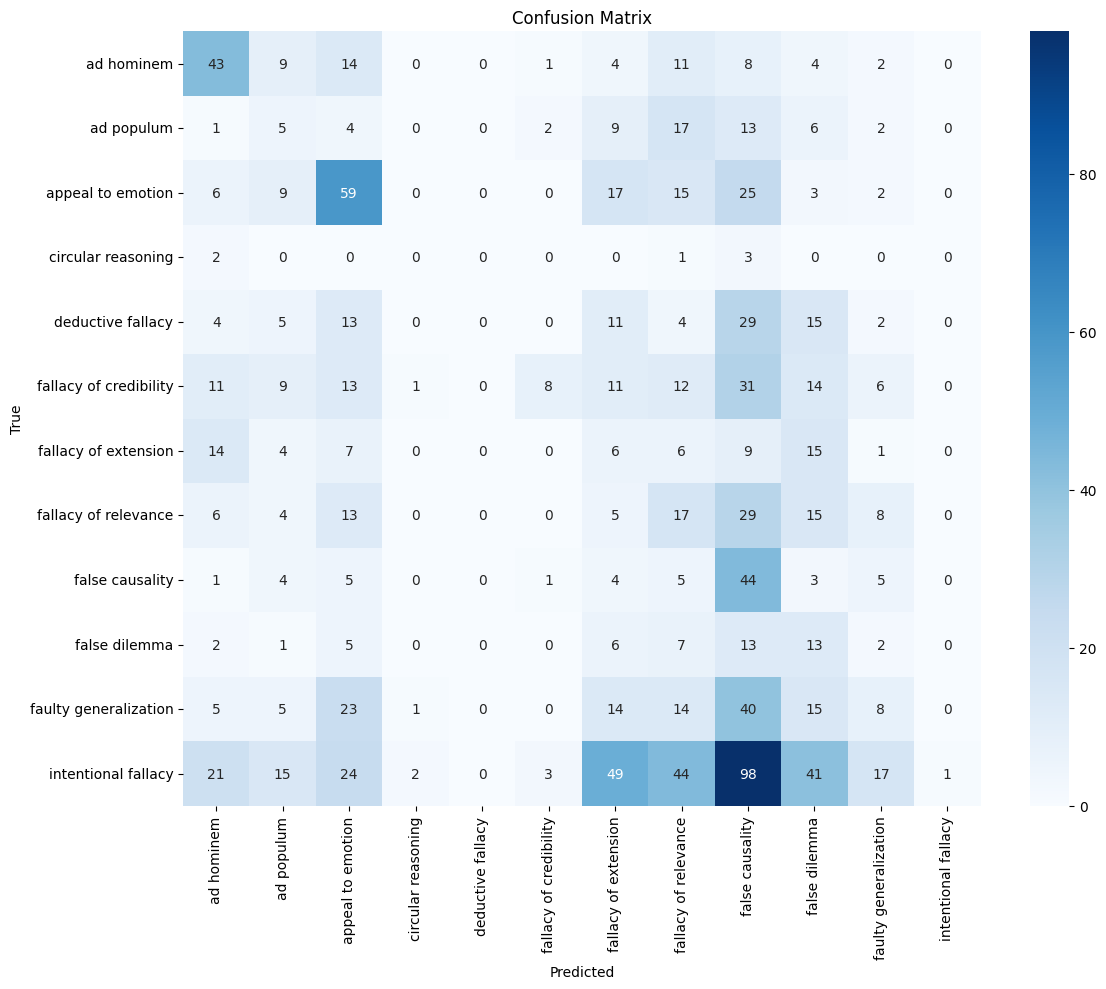

In [120]:
# Zero-shot baseline
logic_climate_baseline_df = climate_predictions()

Running LogicClimate Evaluation: 100%|██████████| 81/81 [07:08<00:00,  5.29s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r


LogicClimate Evaluation Results - Few-shot Prompt
Accuracy: 0.1089

Classification Report:
                        precision    recall  f1-score   support

            ad hominem     0.3291    0.2708    0.2971        96
            ad populum     0.0130    0.0159    0.0143        63
     appeal to emotion     0.3421    0.0922    0.1453       141
    circular reasoning     0.0000    0.0000    0.0000         7
     deductive fallacy     0.0000    0.0000    0.0000        88
fallacy of credibility     0.3051    0.1374    0.1895       131
  fallacy of extension     0.0661    0.1250    0.0865        64
  fallacy of relevance     0.0945    0.2330    0.1345       103
       false causality     0.2042    0.3973    0.2698        73
         false dilemma     0.1311    0.1633    0.1455        49
 faulty generalization     0.1404    0.0602    0.0842       133
   intentional fallacy     0.3846    0.0148    0.0286       337
                  none     0.0000    0.0000    0.0000         0

          

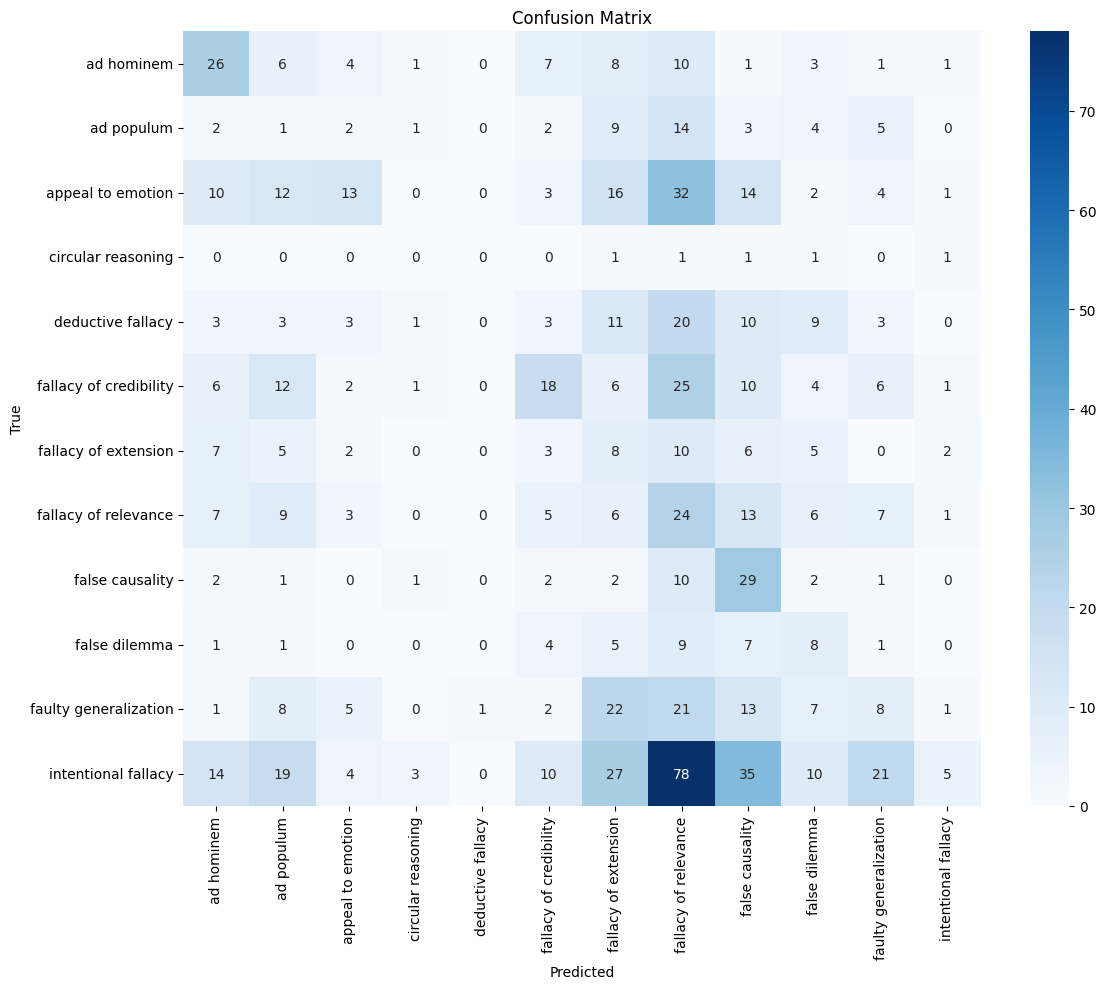

Running LogicClimate Evaluation: 100%|██████████| 81/81 [07:15<00:00,  5.38s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r


LogicClimate Evaluation Results - Few-shot Prompt
Accuracy: 0.1167

Classification Report:
                        precision    recall  f1-score   support

            ad hominem     0.3723    0.3646    0.3684        96
            ad populum     0.0185    0.0159    0.0171        63
     appeal to emotion     0.3390    0.1418    0.2000       141
    circular reasoning     0.0000    0.0000    0.0000         7
     deductive fallacy     0.1613    0.0568    0.0840        88
fallacy of credibility     0.2821    0.1679    0.2105       131
  fallacy of extension     0.0407    0.0781    0.0535        64
  fallacy of relevance     0.1308    0.1650    0.1459       103
       false causality     0.1173    0.2877    0.1667        73
         false dilemma     0.1169    0.1837    0.1429        49
 faulty generalization     0.1375    0.0827    0.1033       133
   intentional fallacy     0.3333    0.0119    0.0229       337
                  none     0.0000    0.0000    0.0000         0

          

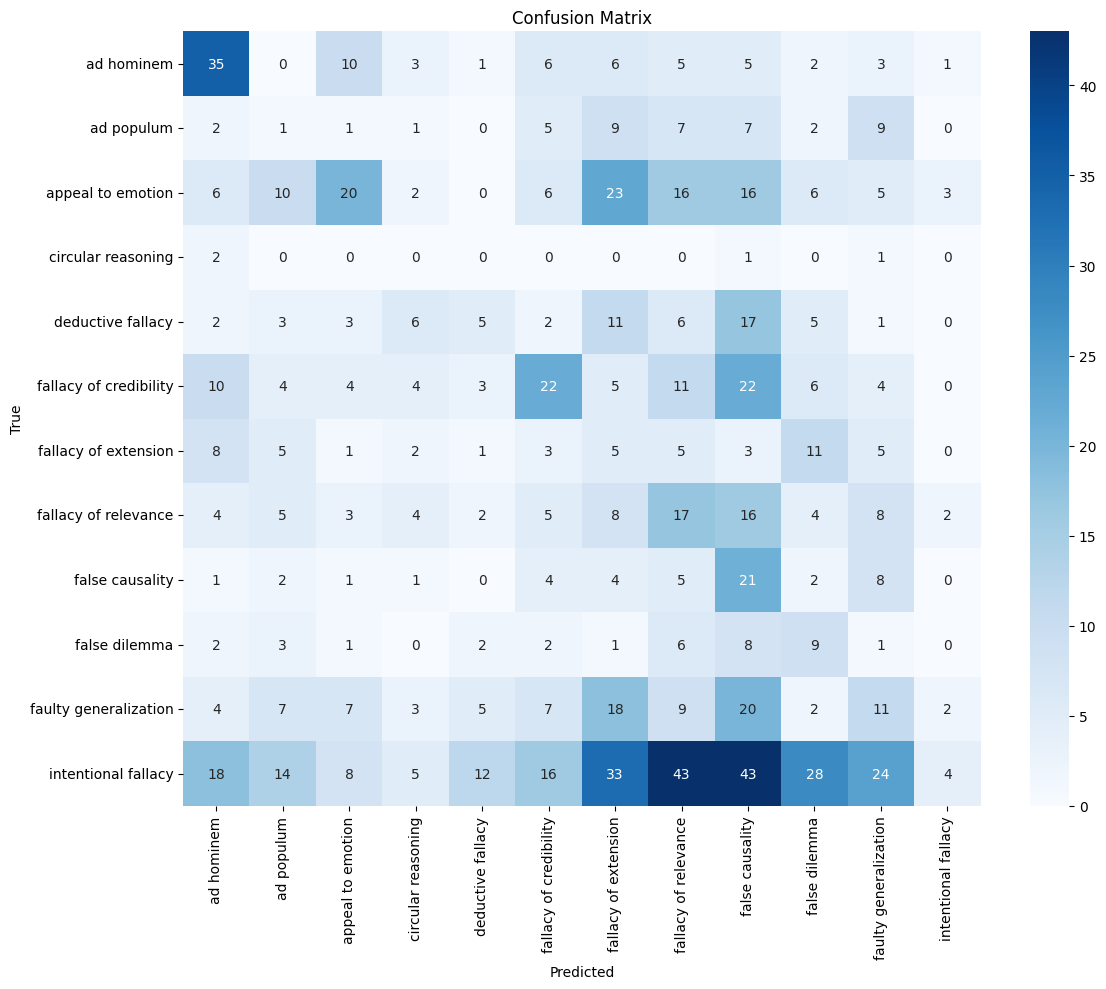

Running LogicClimate Evaluation: 100%|██████████| 81/81 [06:19<00:00,  4.69s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r


LogicClimate Evaluation Results - Few-shot Prompt
Accuracy: 0.0988

Classification Report:
                        precision    recall  f1-score   support

            ad hominem     0.2929    0.3021    0.2974        96
            ad populum     0.0517    0.0476    0.0496        63
     appeal to emotion     0.2353    0.1418    0.1770       141
    circular reasoning     0.0556    0.1429    0.0800         7
     deductive fallacy     0.2500    0.0114    0.0217        88
fallacy of credibility     0.5625    0.0687    0.1224       131
  fallacy of extension     0.0431    0.0781    0.0556        64
  fallacy of relevance     0.0989    0.0874    0.0928       103
       false causality     0.1374    0.2466    0.1765        73
         false dilemma     0.0847    0.1020    0.0926        49
 faulty generalization     0.1116    0.1805    0.1379       133
   intentional fallacy     0.3333    0.0089    0.0173       337
                  none     0.0000    0.0000    0.0000         0

          

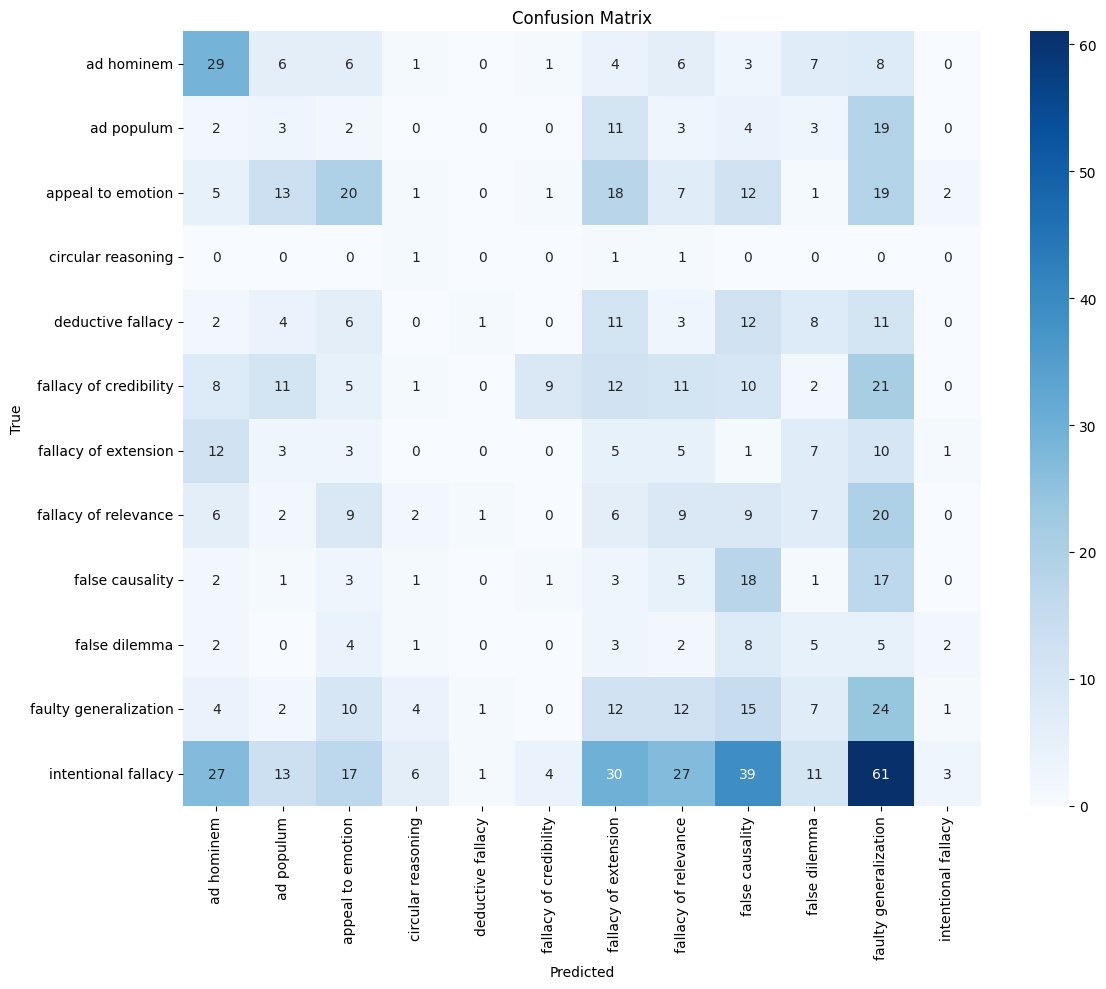

In [121]:
# Active prompting with entropy examples
logic_climate_entropy_df = climate_predictions(examples_context=entropy_examples_context)
logic_climate_disagreement_df = climate_predictions(examples_context=disagreement_examples_context)
logic_climate_inconsistency_df = climate_predictions(examples_context=inconsistency_examples_context)